# Sebastian Garcia
# Text Preprocessing and Topic modeling (German)
        
A dataset of 1628 job ads from job.ch is provided:

The exercise is inspired by this article : 
http://dataskunkworks.com/2018/06/06/extracting-topics-from-11000-newsgroups-posts-with-python-gensim-and-lda/

- Use text preprocessing methods and lexicon normalization to prepare the data and build a dictionary and a text corpus to be used with an LDA model.
- Build a LDA topic model.
- Fine tune the model, try to find the optimal number of topics.
- Provide visuals whenever possible (a Topic-Keywords chart is mandatory)

- Bonus: Remove all unnecessary words from the data and focus on things like noun, verb, etc to perform topic modeling, try also bigrams and trigrams

In [1]:
import pandas as pd
import numpy as np
import re
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
#language detection
from langdetect import detect_langs 
from langdetect import DetectorFactory
from nltk.corpus import stopwords
# spacy for lemmatization
import spacy
# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


C:\Users\okupa\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Data Wrangling

In [2]:
df = pd.read_csv('201906_job_ads.csv')#, index_col=0)


In [3]:
df.head()


,Unnamed: 0,title,company,location,ad_date,size,percent,position,page,job_link,page_link,ad_content
0,0,Fachperson Gesundheit Pflege-Pool,NaN,-,"Saturday, June 15, 2019",Small and medium-sized enterprises,"Unlimited employment,20% – 50%",Employee,1,/en/vacancies/detail/8797234/?position=1-1&sou...,/en/vacancies/?page=1&term=,Für den Ausbau unseres Pools im Bereich Pflege...
1,1,"Software-Entwickler Steuerungstechnik, FH/HF 8...",NaN,-,"Friday, June 14, 2019",Large-scale entreprises,"Unlimited employment,80% – 100%",Position with re­spon­si­bil­i­ties,1,/en/vacancies/detail/9014155/?position=1-2&sou...,/en/vacancies/?page=1&term=,O sterwalder AG ist ein weltweit tätiges Indus...
2,2,"Technischer Spezialist, HVAC ( Heizung, Lüftun...",NaN,-,"Tuesday, June 18, 2019",Large-scale entreprises,"Unlimited employment,100%",Position with re­spon­si­bil­i­ties,1,/en/vacancies/detail/9021836/?position=1-3&sou...,/en/vacancies/?page=1&term=,CSL Behring ist eine Tochtergesellschaft der a...
3,3,Fachmann Fräsen / Drehen (CNC und konventionell),NaN,-,"Tuesday, June 18, 2019",Small and medium-sized enterprises,"Unlimited employment,100%",Position with re­spon­si­bil­i­ties,1,/en/vacancies/detail/9021929/?position=1-4&sou...,/en/vacancies/?page=1&term=,Im Zuge unseres Wachstums bauen wir unsere Fer...
4,4,Qualitätsmanagement Engineer & SiBe,NaN,-,"Tuesday, June 18, 2019",Small and medium-sized enterprises,"Unlimited employment,100%",Position with re­spon­si­bil­i­ties,1,/en/vacancies/detail/9021889/?position=1-5&sou...,/en/vacancies/?page=1&term=,Möchten Sie Ihre Erfahrung und Fachkompetenz i...


In [4]:
df.loc[df['location']== "Tuesday, June 18, 2019"]


,Unnamed: 0,title,company,location,ad_date,size,percent,position,page,job_link,page_link,ad_content
641,Chef/fe de projet 100%,NaN,-,"Tuesday, June 18, 2019",Small and medium-sized enterprises,"Unlimited employment,100%",Position with re­spon­si­bil­i­ties,32,/en/vacancies/detail/8986702/?position=32-15&s...,/en/vacancies/?page=32&term=,Ingénieur/e-électricien/ne - Chef/fe de projet...,NaN
669,Structures et dessin 100%,NaN,-,"Tuesday, June 18, 2019",Small and medium-sized enterprises,"Unlimited employment,100%",Position with re­spon­si­bil­i­ties,33,/en/vacancies/detail/8984088/?position=33-22&s...,/en/vacancies/?page=33&term=,Chef/fe de département Structures et dessin 10...,NaN


In [5]:
df.drop(df.index[[641, 669]], inplace=True)


In [6]:
df.shape


(1628, 12)

In [7]:
df.columns


Index(['Unnamed: 0', 'title', 'company', 'location', 'ad_date', 'size',
       'percent', 'position', 'page', 'job_link', 'page_link', 'ad_content'],
      dtype='object')

# Noise Removal

In [8]:
text_corpus = df.title.values.tolist()
text_corpus = [re.sub('\s+', ' ', doc) for doc in text_corpus] #removing newline characters
text_corpus = [re.sub("\'", "", doc) for doc in text_corpus] #removing single quote characters
text_corpus = [re.sub(r'\b\w{1,3}\b', '', doc) for doc in text_corpus] #removing short words
text_corpus


['Fachperson Gesundheit Pflege-Pool',
 'Software-Entwickler Steuerungstechnik, /  -  % (/)',
 'Technischer Spezialist, HVAC ( Heizung, Lüftung, Klima)',
 'Fachmann Fräsen / Drehen (  konventionell)',
 'Qualitätsmanagement Engineer & SiBe',
 'Filialleiter/  Bern (Westside)',
 'Oberärztin/Oberarzt klinische Kardiologie/ambulante kardiale Rehabilitation -%',
 'Fachspezialist/ Tarife %',
 'Assistentin  Geschäftsleitung',
 'Redaktor/ ( %)',
 'Logistiker/ % temporär .  Monate',
 'Senior Manager, Fill Finish Operations (//) %',
 'Personalrestaurantverantwortlicher  Kochfunktion / (%)',
 'Business Analyst, Supply Chain (/)',
 'Pharma Fachmitarbeiter (/) %',
 'Commissioning, Verification  Qualification  (/) %',
 'Technischer Spezialist  Bereich Wasser (//) %',
 'Betriebstechniker Unterhalt',
 'Praktikant/  %',
 'Landschäftsgärtner',
 'Plattenleger',
 'Zimmermann',
 'Mitarbeiter/ Service/Verpflegungsdienst -%',
 'Senior  Security Architect (/, %)',
 'Senior  Security Architect (/, %)',
 'Fachfra

# Select only job ads written in German

In [9]:
#Use fast.ai (from Facebook) for language detection -> the one I use here is not that good
DetectorFactory.seed = 0 # Deterministic results

text_lang = []
for text in text_corpus:
    try:
        lang_probs = detect_langs(text)
        text_lang.append(lang_probs[0].lang)
    except:
        lang_probs = 'error'


In [10]:
 # text_lang is a list of strings that are indicating the most probable language
text_corpus_germ = [text for text, lang in zip(text_corpus, text_lang) if lang=='de']  # select German only


In [11]:
len(text_corpus_germ)


852

# Tokenising words

    Breaking up a sequence of strings into pieces, called tokens.

In [12]:
warnings.simplefilter("ignore", DeprecationWarning)

def doc_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

words = list(doc_to_words(text_corpus_germ))
 
words


[['fachperson', 'gesundheit', 'pflege', 'pool'],
 ['software', 'entwickler'],
 ['technischer', 'spezialist', 'hvac', 'heizung', 'luftung', 'klima'],
 ['fachmann', 'frasen', 'drehen', 'konventionell'],
 ['engineer', 'sibe'],
 ['filialleiter', 'bern', 'westside'],
 ['oberarztin',
  'oberarzt',
  'klinische',
  'kardiologie',
  'ambulante',
  'kardiale',
  'rehabilitation'],
 ['fachspezialist', 'tarife'],
 ['assistentin'],
 ['kochfunktion'],
 ['pharma', 'fachmitarbeiter'],
 ['technischer', 'spezialist', 'bereich', 'wasser'],
 ['unterhalt'],
 [],
 ['plattenleger'],
 ['zimmermann'],
 ['mitarbeiter', 'service'],
 ['fachfrau', 'mann', 'gesundheit', 'unserem', 'team'],
 ['verkaufer', 'topshop'],
 ['chauffeur', 'kategorie'],
 ['flexible', 'moglich'],
 ['auftrag', 'hauswartung', 'abruf', 'juli', 'oder', 'nach', 'vereinbarung'],
 ['maschinisten'],
 ['dipl', 'ergotherapeuten'],
 [],
 ['bodenleger'],
 ['zurich', 'bern'],
 ['assistenzarztin',
  'assistenzarzt',
  'notfall',
  'zentrum',
  'zentrum',

# Removing stopwords

In [13]:
stop_words = stopwords.words('german')

# Add additional options
stop_words.extend(['deshalb', 'name', 'allgemein', 'insbesondere', 'einzig'])
 
def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in text_corpus_germ]

# Apply the function for removing stopwords
words = remove_stopwords(words)
 
words

[['fachperson', 'gesundheit', 'pflege', 'pool'],
 ['software', 'entwickler'],
 ['technischer', 'spezialist', 'hvac', 'heizung', 'lüftung', 'klima'],
 ['fachmann', 'fräsen', 'drehen', 'konventionell'],
 ['engineer', 'sibe'],
 ['filialleiter', 'bern', 'westside'],
 ['oberärztin',
  'oberarzt',
  'klinische',
  'kardiologie',
  'ambulante',
  'kardiale',
  'rehabilitation'],
 ['fachspezialist', 'tarife'],
 ['assistentin'],
 ['kochfunktion'],
 ['pharma', 'fachmitarbeiter'],
 ['technischer', 'spezialist', 'bereich', 'wasser'],
 ['unterhalt'],
 [],
 ['plattenleger'],
 ['zimmermann'],
 ['mitarbeiter', 'service'],
 ['fachfrau', 'mann', 'gesundheit', 'team'],
 ['verkäufer', 'topshop'],
 ['chauffeur', 'kategorie'],
 ['flexible', 'möglich'],
 ['auftrag', 'hauswartung', 'abruf', 'juli', 'vereinbarung'],
 ['maschinisten'],
 ['dipl', 'ergotherapeuten'],
 [],
 ['bodenleger'],
 ['zürich', 'bern'],
 ['assistenzärztin',
  'assistenzarzt',
  'notfall',
  'zentrum',
  'zentrum',
  'innere',
  'medizin'],


# Creating the dictionary and the corpus

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(words)
 
# Create Corpus
corpus = [id2word.doc2bow(text) for text in words]
 
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           per_word_topics=True)


In [15]:
corpus


[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1)],
 [(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)],
 [(12, 1), (13, 1), (14, 1), (15, 1)],
 [(16, 1), (17, 1)],
 [(18, 1), (19, 1), (20, 1)],
 [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)],
 [(28, 1), (29, 1)],
 [(30, 1)],
 [(31, 1)],
 [(32, 1), (33, 1)],
 [(10, 1), (11, 1), (34, 1), (35, 1)],
 [(36, 1)],
 [],
 [(37, 1)],
 [(38, 1)],
 [(39, 1), (40, 1)],
 [(1, 1), (41, 1), (42, 1), (43, 1)],
 [(44, 1), (45, 1)],
 [(46, 1), (47, 1)],
 [(48, 1), (49, 1)],
 [(50, 1), (51, 1), (52, 1), (53, 1), (54, 1)],
 [(55, 1)],
 [(56, 1), (57, 1)],
 [],
 [(58, 1)],
 [(18, 1), (59, 1)],
 [(60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2)],
 [(66, 1), (67, 1)],
 [(67, 1), (68, 1), (69, 1)],
 [(70, 1), (71, 1), (72, 1)],
 [(73, 1), (74, 1)],
 [(33, 1), (75, 1), (76, 1)],
 [(77, 1), (78, 1)],
 [(11, 1), (79, 1), (80, 1)],
 [(39, 1), (81, 1), (82, 1)],
 [(1, 1), (41, 2), (42, 2), (83, 1)],
 [(84, 1), (85, 1)],
 [(86, 1), (87, 1)],


In [16]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.020*"engineer" + 0.016*"sales" + 0.013*"manager" + 0.009*"mitarbeiter" + '
  '0.009*"services" + 0.009*"region" + 0.009*"assistenz" + 0.009*"assistant" + '
  '0.007*"business" + 0.007*"product"'),
 (1,
  '0.023*"gesundheit" + 0.018*"fachfrau" + 0.018*"projektleiter" + '
  '0.015*"mann" + 0.014*"marketing" + 0.011*"innendienst" + 0.009*"leiter" + '
  '0.009*"spezialist" + 0.008*"sachbearbeiter" + 0.008*"manager"'),
 (2,
  '0.017*"assistent" + 0.011*"manager" + 0.010*"sachbearbeiter" + '
  '0.010*"senior" + 0.010*"product" + 0.010*"projektleiter" + 0.009*"junior" + '
  '0.008*"dipl" + 0.008*"assistant" + 0.008*"team"'),
 (3,
  '0.026*"leiter" + 0.017*"dipl" + 0.017*"sachbearbeiter" + '
  '0.014*"mitarbeiter" + 0.011*"aussendienst" + 0.009*"bereich" + '
  '0.009*"pflegefachfrau" + 0.009*"fachspezialist" + 0.008*"mann" + '
  '0.008*"fachfrau"'),
 (4,
  '0.032*"sachbearbeiter" + 0.017*"mitarbeiter" + 0.016*"manager" + '
  '0.013*"senior" + 0.011*"software" + 0.011*"technicien" + 0

# Benchmarking

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.



Perplexity:  -7.5307562024163675


# Coherence Score

In [18]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.723460389543542


In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


# Tuning
Find the optimal number of topics

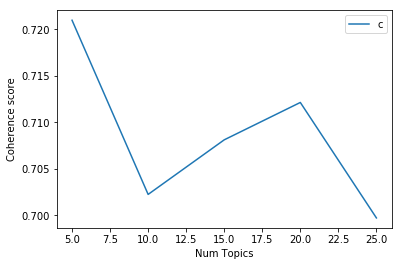

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words, start=5, limit=30, step=5)

# Show graph
import matplotlib.pyplot as plt
limit=30; start=5; step=5;
x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


# Visualising the topic model

In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


C:\Users\okupa\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.013060 -0.087965       1        1  23.793627
1     -0.053796 -0.083599       2        1  21.254866
3     -0.109595  0.080461       3        1  20.351954
0      0.101558  0.019441       4        1  17.607121
2      0.048774  0.071662       5        1  16.992432, topic_info=    Category       Freq            Term      Total  loglift  logprob
89   Default  17.000000          leiter  17.000000  30.0000  30.0000
1    Default  14.000000      gesundheit  14.000000  29.0000  29.0000
131  Default  13.000000   projektleiter  13.000000  28.0000  28.0000
104  Default  10.000000       assistent  10.000000  27.0000  27.0000
41   Default  14.000000        fachfrau  14.000000  26.0000  26.0000
109  Default  32.000000  sachbearbeiter  32.000000  25.0000  25.0000
192  Default   8.000000       marketing   8.000000  24.0000  24.0000
237  Default  10.000000           sales  10.000000  23.0000  23.0000
42   Default  13.000000            mann  13.000000  22.0000  22.0000
16   Default  16.000000        engineer  16.000000  21.0000  21.0000
164  Default   6.000000     innendienst   6.000000  20.0000  20.0000
159  Default   6.000000    aussendienst   6.000000  19.0000  19.0000
185  Default   4.000000  pflegefachfrau   4.000000  18.0000  18.0000
145  Default   6.000000      teamleiter   6.000000  17.0000  17.0000
28   Default   6.000000  fachspezialist   6.000000  16.0000  16.0000
238  Default  10.000000         product  10.000000  15.0000  15.0000
94   Default   5.000000          region   5.000000  14.0000  14.0000
34   Default   8.000000         bereich   8.000000  13.0000  13.0000
464  Default   7.000000      technicien   7.000000  12.0000  12.0000
112  Default   6.000000        services   6.000000  11.0000  11.0000
70   Default   6.000000       assistenz   6.000000  10.0000  10.0000
174  Default   3.000000         trainee   3.000000   9.0000   9.0000
246  Default   9.000000       assistant   9.000000   8.0000   8.0000
10   Default   6.000000      spezialist   6.000000   7.0000   7.0000
56   Default  16.000000            dipl  16.000000   6.0000   6.0000
157  Default   5.000000  rechnungswesen   5.000000   5.0000   5.0000
43   Default   6.000000            team   6.000000   4.0000   4.0000
129  Default   6.000000          system   6.000000   3.0000   3.0000
186  Default   3.000000  pflegefachmann   3.000000   2.0000   2.0000
712  Default   3.000000      betreuerin   3.000000   1.0000   1.0000
..       ...        ...             ...        ...      ...      ...
193   Topic5   2.169815         project   4.093814   1.1376  -5.1410
126   Topic5   2.149479     lehrstellen   4.056113   1.1374  -5.1504
469   Topic5   2.141314       infirmier   4.056553   1.1335  -5.1542
752   Topic5   1.489659      mécanicien   2.707904   1.1748  -5.5170
289   Topic5   1.488015      rapperswil   2.707791   1.1737  -5.5182
344   Topic5   1.483831  hauswirtschaft   2.707849   1.1709  -5.5210
628   Topic5   1.485695         quality   2.715994   1.1691  -5.5197
370   Topic5   1.486417    applikations   2.737229   1.1618  -5.5192
30    Topic5   1.478042     assistentin   2.736872   1.1563  -5.5249
43    Topic5   2.841391            team   6.094782   1.0093  -4.8713
130   Topic5   3.514095          junior   9.529369   0.7748  -4.6588
238   Topic5   3.533446         product  10.163544   0.7159  -4.6533
561   Topic5   1.494094        dynamics   3.384191   0.9548  -5.5141
317   Topic5   1.491883       ingenieur   3.392376   0.9509  -5.5156
326   Topic5   1.477472       disponent   3.383661   0.9438  -5.5253
131   Topic5   3.532932   projektleiter  13.127902   0.4598  -4.6535
246   Topic5   2.848961       assistant   9.550241   0.5628  -4.8686
120   Topic5   3.543291          senior  16.308201   0.2458  -4.6505
100   Topic5   4.226593         manager  23.095356   0.0742  -4.4742
45    Topic5   2.164091       verkäufer   7.442149   0.5372 

# Practical applications of the topic model

In [30]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_corpus_germ):
    # Array of top 10 topics
    top10array = []
 
    for row in range(ldamodel.num_topics):
        wp = ldamodel.show_topic(row)
        topic_keywords = ", ".join([word for word, prop in wp])
        top10array.append((row+1, topic_keywords))
 
    top10dict = dict(top10array)
 
    sent_topics_df = pd.DataFrame(pd.DataFrame([sorted(topic[0], key=lambda x: (x[1]), reverse=True) for topic in ldamodel[corpus]])[0])
    sent_topics_df.columns=["Data"]
    sent_topics_df['Dominant_Topic'] = sent_topics_df.Data.apply(lambda x: x[0]+1)
    sent_topics_df['Perc_Contribution'] = sent_topics_df.Data.apply(lambda x: round(x[1],4))
    sent_topics_df['Topic_Keywords'] = sent_topics_df.Dominant_Topic.apply(lambda x: top10dict[x])
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Text")], axis=1)
    sent_topics_df = sent_topics_df[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']]
    return(sent_topics_df)
 
df_topic_sents_keywords = format_topics_sentences()
df_topic_sents_keywords.head()


,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,2,0.8385,"gesundheit, fachfrau, projektleiter, mann, mar...",Fachperson Gesundheit Pflege-Pool
1,5,0.7300,"sachbearbeiter, mitarbeiter, manager, senior, ...","Software-Entwickler Steuerungstechnik, / - %..."
2,4,0.8844,"leiter, dipl, sachbearbeiter, mitarbeiter, aus...","Technischer Spezialist, HVAC ( Heizung, Lüftun..."
3,2,0.8398,"gesundheit, fachfrau, projektleiter, mann, mar...",Fachmann Fräsen / Drehen ( konventionell)
4,4,0.4203,"leiter, dipl, sachbearbeiter, mitarbeiter, aus...",Qualitätsmanagement Engineer & SiBe


In [31]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()
 
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
 
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)
 
# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
 
# Show
sent_topics_sorteddf.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.9271,"engineer, sales, manager, mitarbeiter, service...",(Cardiac Rhythm Management) Field Engineer Re...
1,2,0.9102,"gesundheit, fachfrau, projektleiter, mann, mar...",Fachfrau/- mann Gesundheit Spitex Temporär ...
2,3,0.8998,"assistent, manager, sachbearbeiter, senior, pr...",Oberärztin/Oberarzt klinische Kardiologie/ambu...
3,4,0.9097,"leiter, dipl, sachbearbeiter, mitarbeiter, aus...","Export & Sales Administration -%, Aushilfe vi..."
4,5,0.9196,"sachbearbeiter, mitarbeiter, manager, senior, ...",Java full stack Developer / Senior Java full s...
